In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import sklearn as skt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [70]:
df = pd.read_csv("Datasets/accesos_biblioteca.csv")
df_c=df
df.head()

,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?
0,2023-12-14,14,12,2023,2,953,0
1,2023-12-15,15,12,2023,2,549,0
2,2023-12-16,16,12,2023,2,71,0
3,2023-12-17,17,12,2023,2,0,1
4,2023-12-18,18,12,2023,2,739,0


In [71]:
# max = ((df['Accesos'].max())//100)+2
# max = ((df['Accesos'].max())//500)+2
max = ((df['Accesos'].max())//1000)+2
print(max)

6


In [72]:
bins = [0]
labels = []
# for i in range(max):
#     bins.append(50+i*100)
#     labels.append(i)
# for i in range(max):
#     bins.append((i+1)*500)
#     labels.append(i+1)
for i in range(max):
    bins.append((i+1)*1000)
    labels.append(i)
df['Access'] = pd.cut(df['Accesos'], bins=bins, labels=labels, right=False)

print(df)

          Fecha  Día  Mes   Año  Semestre  Accesos  Vacaciones? Access
0    2023-12-14   14   12  2023         2      953            0      0
1    2023-12-15   15   12  2023         2      549            0      0
2    2023-12-16   16   12  2023         2       71            0      0
3    2023-12-17   17   12  2023         2        0            1      0
4    2023-12-18   18   12  2023         2      739            0      0
..          ...  ...  ...   ...       ...      ...          ...    ...
506  2025-05-03    3    5  2025         1        0            1      0
507  2025-05-04    4    5  2025         1        0            1      0
508  2025-05-05    5    5  2025         1     2750            0      2
509  2025-05-06    6    5  2025         1     1866            0      1
510  2025-05-07    7    5  2025         1     2254            0      2

[511 rows x 8 columns]


<Axes: >

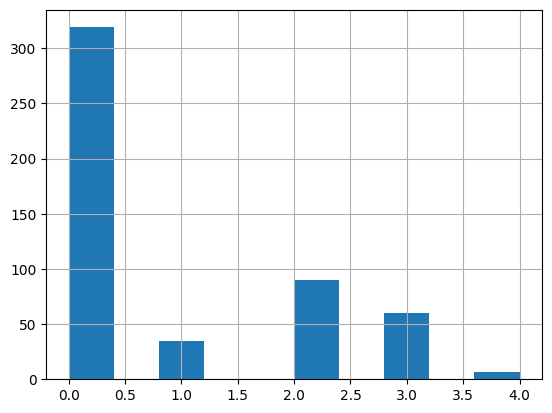

In [73]:
df['Access'].hist()

In [74]:
X= df.drop(['Accesos','Fecha', 'Access','Año', 'Semestre'], axis=1)
Y= df['Access']
X.head()
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# pca = PCA(n_components=0.80) 
# X = pca.fit_transform(X)}

,Día,Mes,Vacaciones?
0,14,12,0
1,15,12,0
2,16,12,0
3,17,12,1
4,18,12,0


In [75]:
X_train, X_test, Y_train, Y_test = skt.model_selection.train_test_split(X, Y, test_size=0.25,shuffle=False) #, stratify=Y, random_state=42


In [76]:
def graph1(Y_pred):
    fechas = df['Fecha']
    plt.figure(figsize=(14, 7))
    plt.plot(fechas, df['Access'], label='Datos reales (train + test)', color='blue', linewidth=2)
    plt.plot(fechas.loc[X_test.index], Y_pred, label='Predicción (test)', color='red', linestyle='--', linewidth=2)
    plt.title('Accesos reales y predicción en el test', fontsize=14)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Número de Accesos', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    print(f"R²: {r2:.2f}")
    print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
    print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.2f}")
    print(f"Error Absoluto Medio (MAE): {mae:.2f}")

In [77]:
def graph2(Y_pred):
    results_df = pd.DataFrame({
        'Índice': X_test.index,
        'Real': Y_test,
        'Predicción': Y_pred
    }).sort_values(by='Índice')

    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Índice'], results_df['Real'], label='Real', color='blue', linewidth=2)
    plt.plot(results_df['Índice'], results_df['Predicción'], label='Predicción', color='green', linestyle='--', linewidth=2)
    plt.title('Resultados de Predicción', fontsize=14)
    plt.xlabel('Índice', fontsize=12)
    plt.ylabel('Número de Accesos', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

In [78]:
def treeimportance(clf):
    #-------------------------------------------------------------------------------
    import time

    start_time   = time.time()
    importances  = clf.feature_importances_
    std          = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    elapsed_time = time.time() - start_time

    print(110*"_")
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
    print(110*"_")

    graph_df = df.drop(['Accesos','Fecha','Access','Año','Semestre'], axis=1)
    forest_importances = pd.Series(importances, index=graph_df.columns)

    # Graficamos -------------------------------------------------------------------
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    #ax.yaxis.set_major_locator(MultipleLocator(0.01))
    ax.tick_params(axis='x', labelsize = 6)
    fig.tight_layout()
    #-------------------------------------------------------------------------------

______________________________________________________________________________________________________________
Elapsed time to compute the importances: 0.010 seconds
______________________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        88
           1       0.00      0.00      0.00         5
           2       0.62      0.53      0.57        19
           3       0.30      0.58      0.40        12
           4       0.44      1.00      0.62         4

    accuracy                           0.75       128
   macro avg       0.47      0.59      0.50       128
weighted avg       0.82      0.75      0.77       128

[[75  5  2  4  2]
 [ 0  0  2  3  0]
 [ 0  0 10  9  0]
 [ 0  0  2  7  3]
 [ 0  0  0  0  4]]


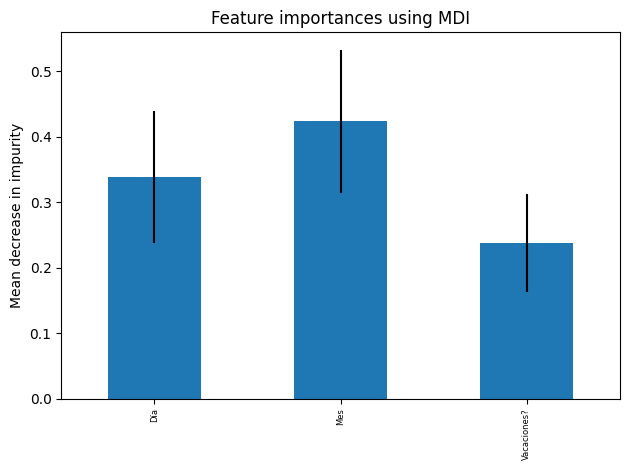

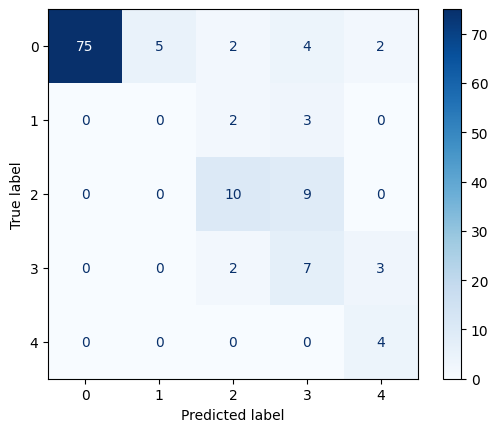

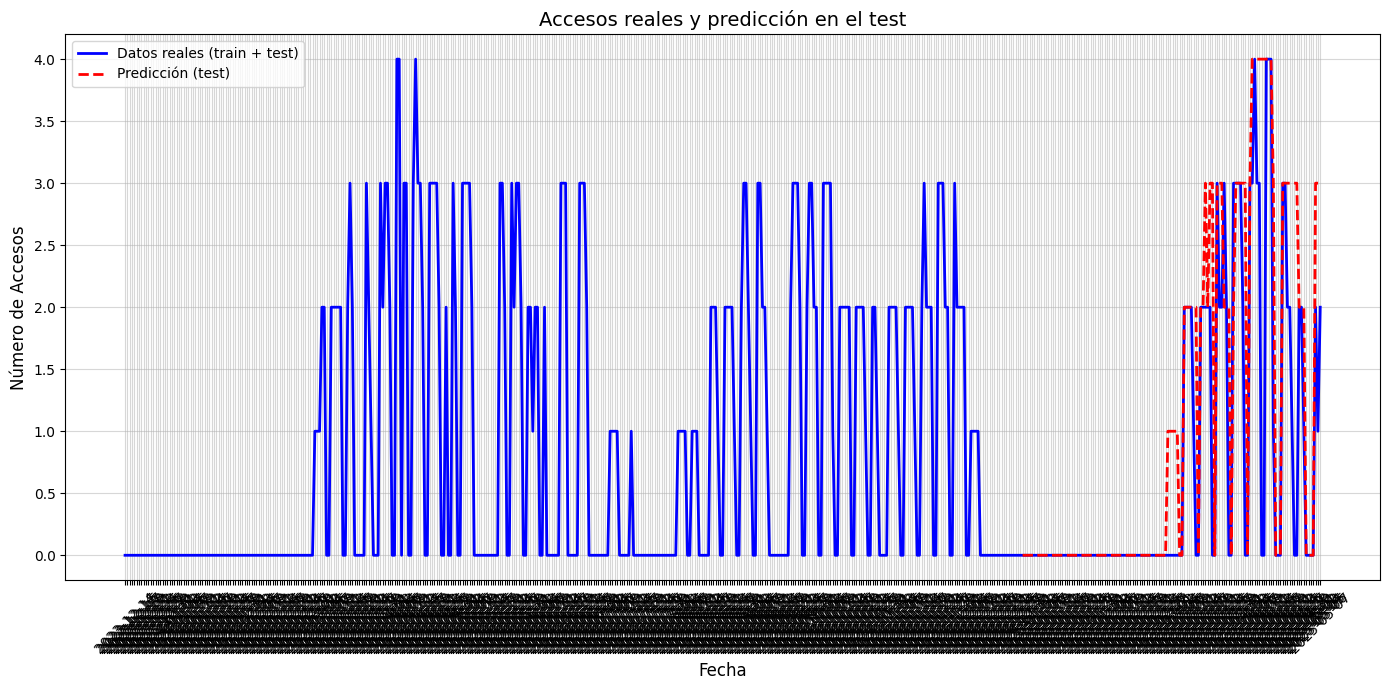

R²: 0.40
Error Cuadrático Medio (MSE): 0.85
Error Cuadrático Medio Raíz (RMSE): 0.92
Error Absoluto Medio (MAE): 0.40


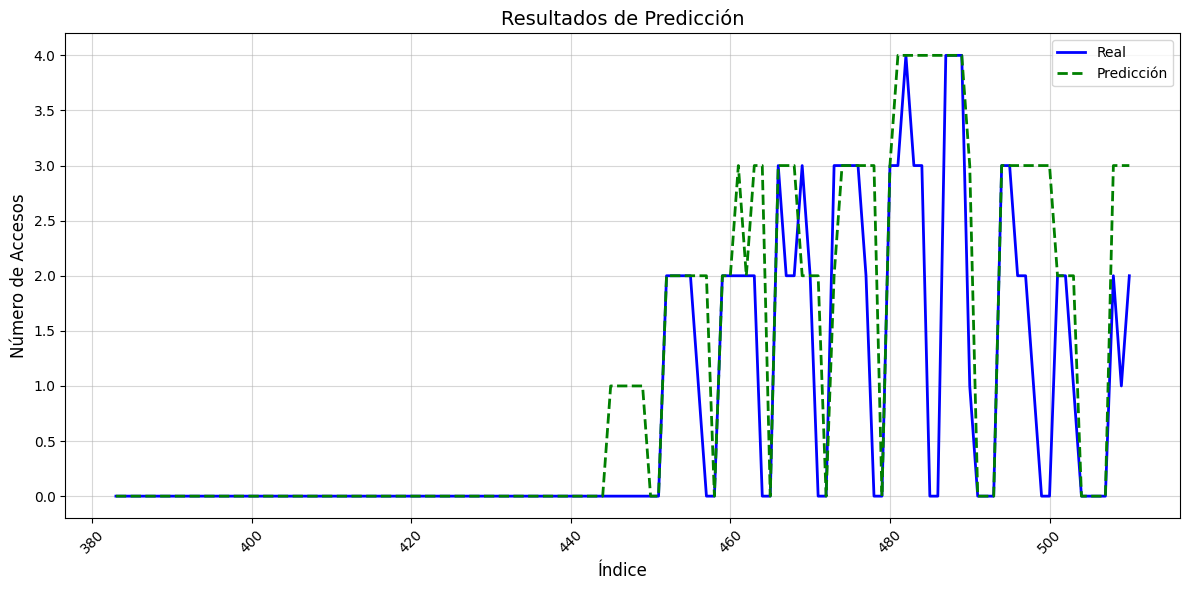

In [79]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5,  max_features='sqrt', min_samples_leaf=2, class_weight='balanced')
clf.fit(X_train, Y_train)
treeimportance(clf)
Y_pred = clf.predict(X_test)
f1_score(Y_test, Y_pred, average='weighted')
print(classification_report(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, cmap=plt.cm.Blues)
graph1(Y_pred)
graph2(Y_pred)


______________________________________________________________________________________________________________
Elapsed time to compute the importances: 0.009 seconds
______________________________________________________________________________________________________________


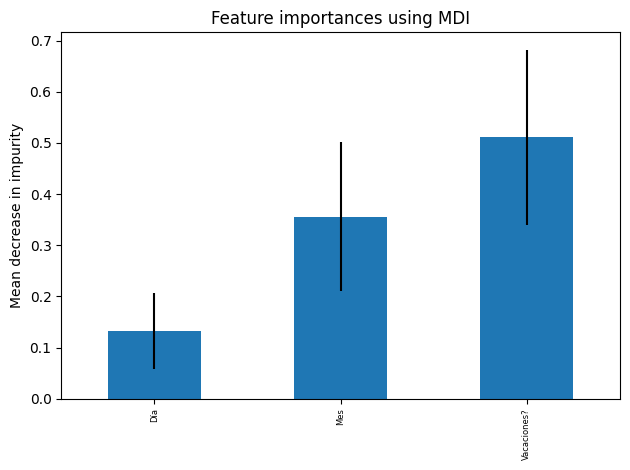

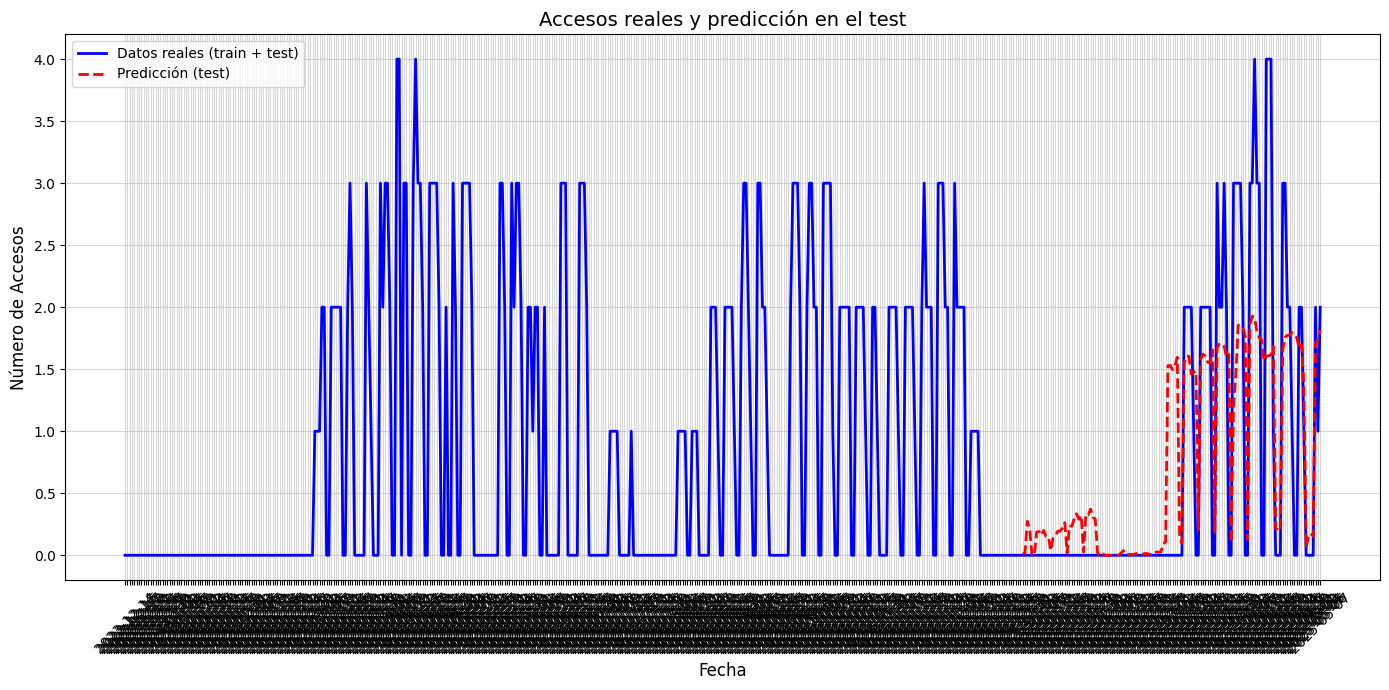

R²: 0.55
Error Cuadrático Medio (MSE): 0.65
Error Cuadrático Medio Raíz (RMSE): 0.80
Error Absoluto Medio (MAE): 0.50


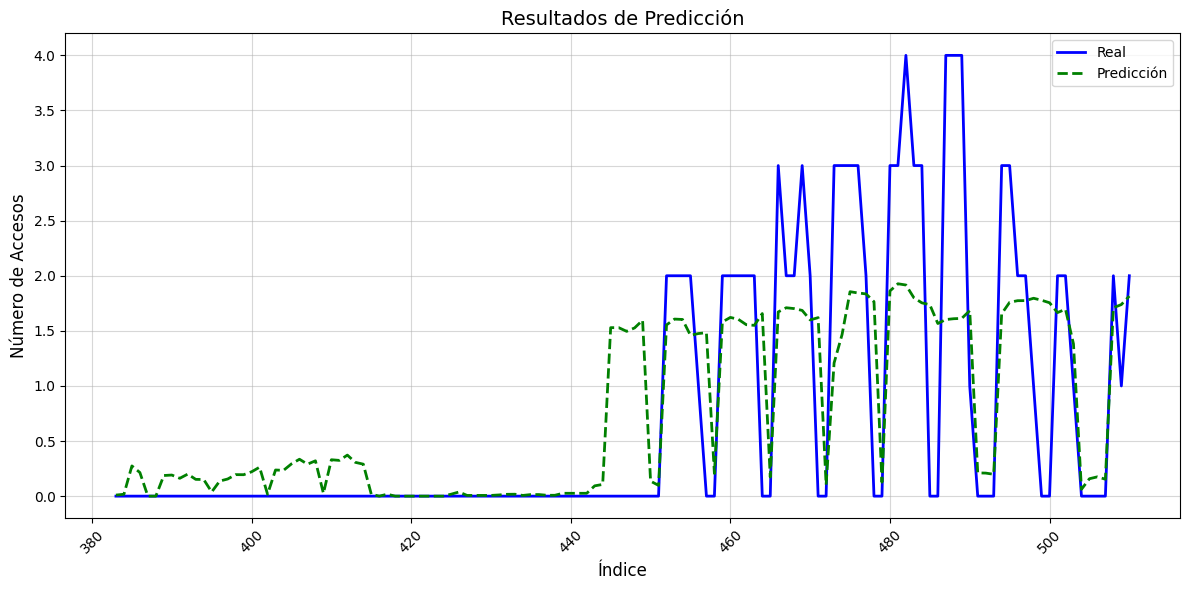

In [80]:
clf = RandomForestRegressor(n_estimators=100, max_depth=5,  max_features='sqrt', min_samples_leaf=2)
clf.fit(X_train, Y_train)
treeimportance(clf)
Y_pred = clf.predict(X_test)
graph1(Y_pred)
graph2(Y_pred)

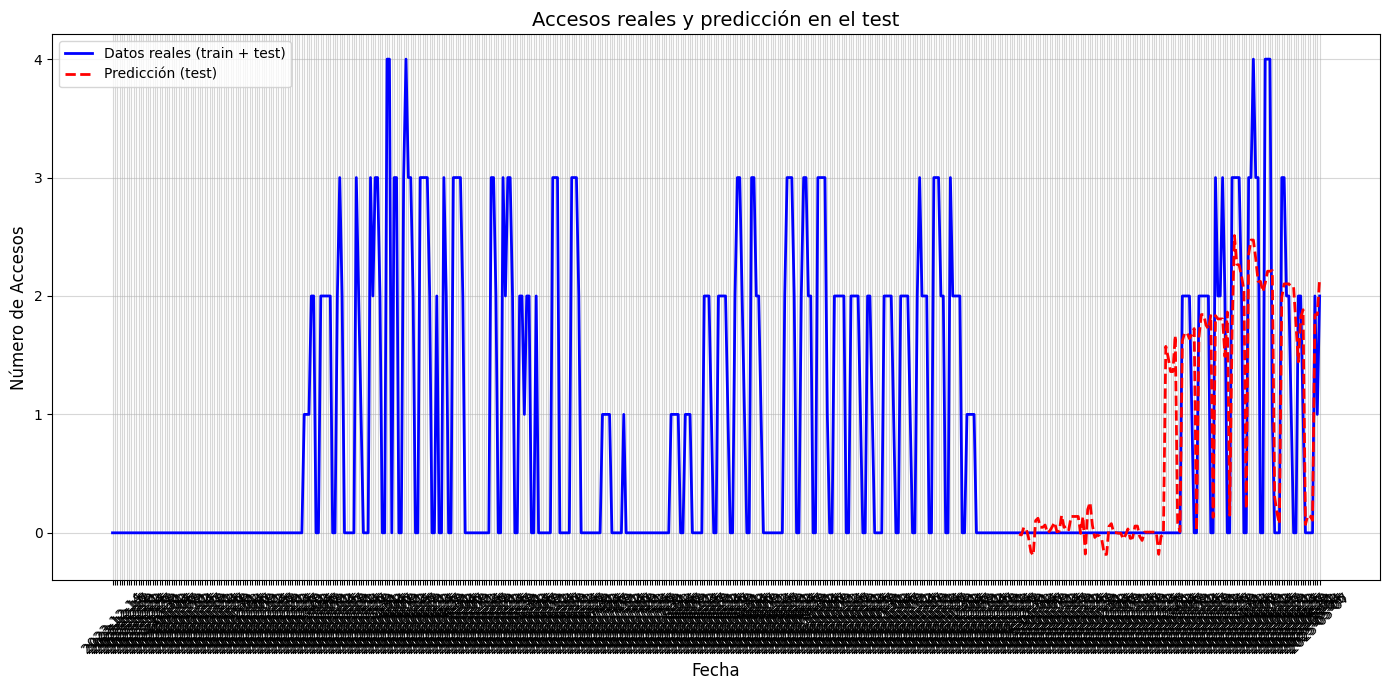

R²: 0.62
Error Cuadrático Medio (MSE): 0.55
Error Cuadrático Medio Raíz (RMSE): 0.74
Error Absoluto Medio (MAE): 0.43


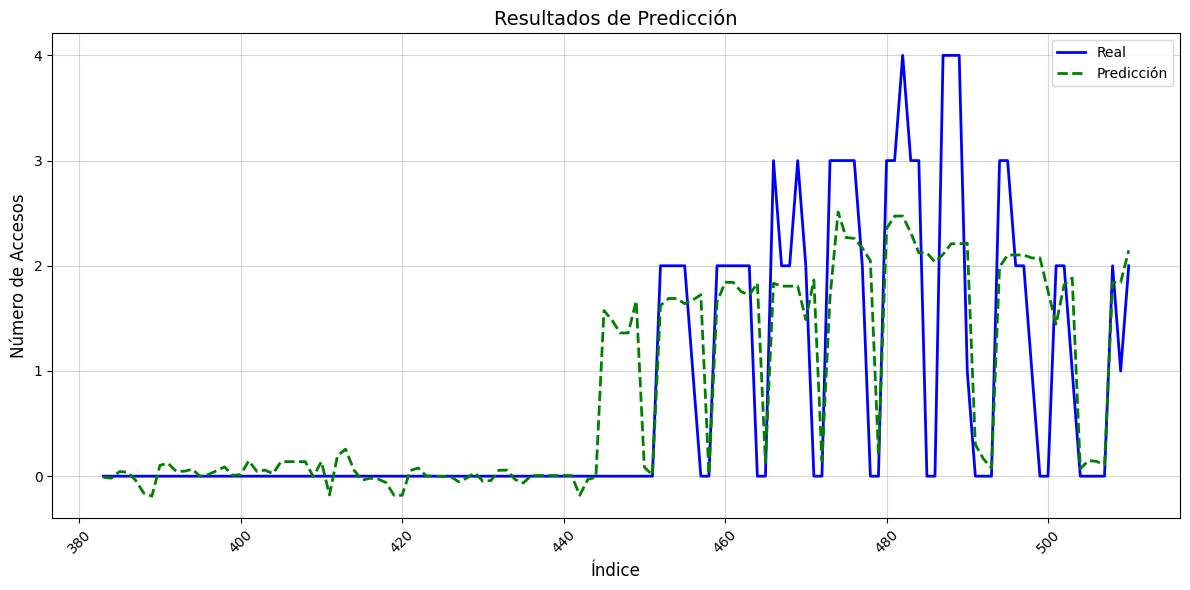

In [81]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3,
    random_state=42
)
xgb_model.fit(X_train, Y_train)
Y_pred = xgb_model.predict(X_test)
graph1(Y_pred)
graph2(Y_pred)

              precision    recall  f1-score   support

           0       0.97      0.85      0.91        88
           1       0.00      0.00      0.00         5
           2       0.55      0.58      0.56        19
           3       0.31      0.67      0.42        12
           4       0.50      0.25      0.33         4

    accuracy                           0.74       128
   macro avg       0.47      0.47      0.45       128
weighted avg       0.80      0.74      0.76       128

[[75  3  5  5  0]
 [ 0  0  2  3  0]
 [ 1  0 11  7  0]
 [ 1  0  2  8  1]
 [ 0  0  0  3  1]]


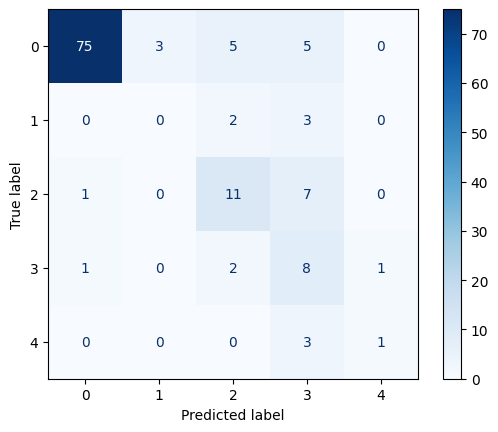

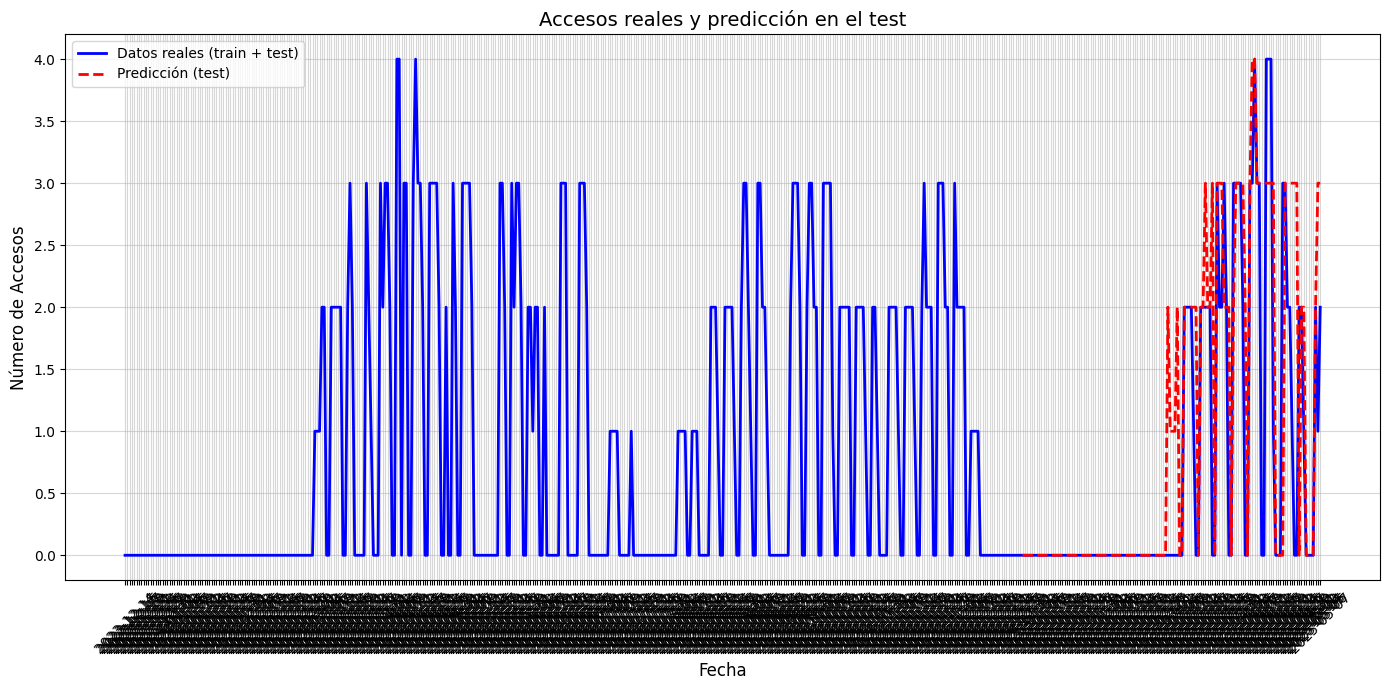

R²: 0.41
Error Cuadrático Medio (MSE): 0.84
Error Cuadrático Medio Raíz (RMSE): 0.92
Error Absoluto Medio (MAE): 0.42


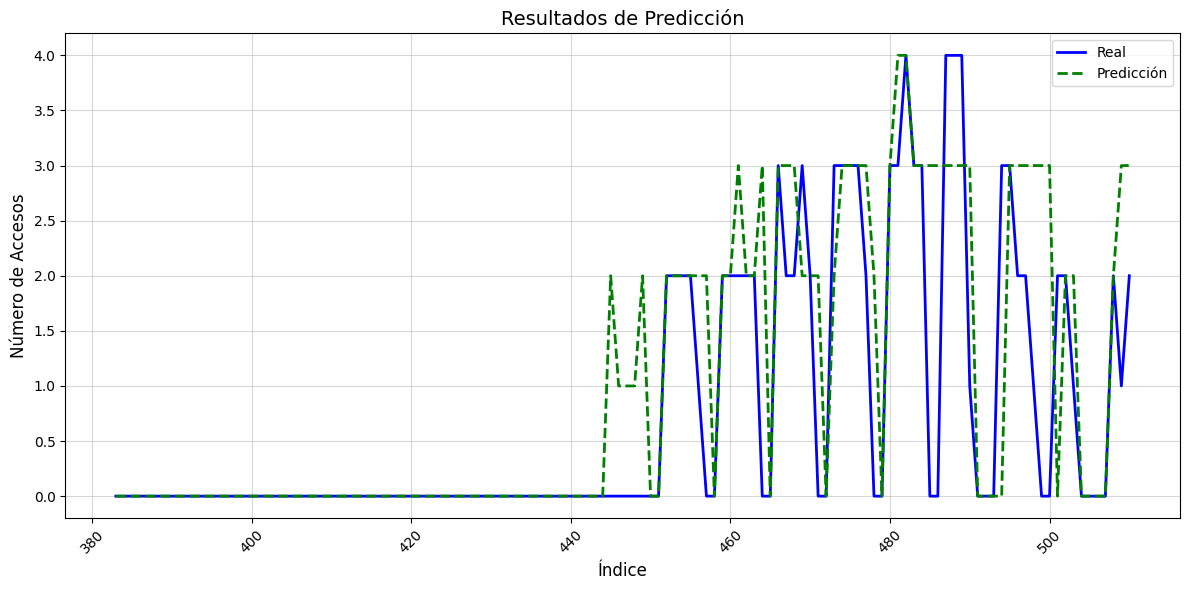

In [82]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, Y_train)
Y_pred = xgb_model.predict(X_test)
f1_score(Y_test, Y_pred, average='weighted')
print(classification_report(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, cmap=plt.cm.Blues)
graph1(Y_pred)
graph2(Y_pred)